In [180]:
fidx = 'ens'
midx = '1'
threshold = -1.38
print(fidx,midx,threshold)

ens 1 -1.38


In [181]:
# results from ens_oof.ipynb
mnames = ['iv3_a1','irv2_a1','se_resnext_a9','resnet34_46']
weights = [1,1,1,5]
assert(len(mnames)==len(weights))
print(mnames)
print(weights)

['iv3_a1', 'irv2_a1', 'se_resnext_a9', 'resnet34_46']
[1, 1, 1, 5]


In [182]:
klist = ['resnet34_46']
print(klist)

['resnet34_46']


In [183]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

from scipy.special import logit, expit

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [184]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [185]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [186]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [187]:
test_df.columns

Index(['Predicted'], dtype='object')

In [188]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [189]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

nfold = 20

firstm = True

klist

for m in mnames:

    firstf = True
    if m in klist: suffix = '.pkl'
    else: suffix = '_bag.pkl'
    for fold in range(nfold):
        # print('')
        # print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print('')
                print(fname)
                idb, ptestb = pickle.load(open(fname,'rb'))
                if m in klist: 
                    ptestb = logit(ptestb)
                
                ptestb = np.clip(ptestb,-6.0,6.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                    
                nr += 1
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,nr,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/iv3_a1_0_bag.pkl
-6.0 -4.2462173 1.6556447
(11702, 28) -6.0 -4.2462173 1.6556447

./sub/iv3_a1_1_bag.pkl
-6.0 -4.774103 6.0
(11702, 28) -6.0 -4.774103 6.0
[[1.         0.71843217]
 [0.71843217 1.        ]]

./sub/iv3_a1_2_bag.pkl
-6.0 -4.8116436 6.0
(11702, 28) -6.0 -4.8116436 6.0
[[1.        0.9232942]
 [0.9232942 1.       ]]

./sub/iv3_a1_3_bag.pkl
-6.0 -4.7986145 6.0
(11702, 28) -6.0 -4.7986145 6.0
[[1.         0.95559135]
 [0.95559135 1.        ]]

./sub/iv3_a1_4_bag.pkl
-6.0 -4.8122125 6.0
(11702, 28) -6.0 -4.8122125 6.0
[[1.         0.96210165]
 [0.96210165 1.        ]]
iv3_a1 0 (11702, 28) -6.0 -4.688558 5.131129 0.06762275068974778

./sub/irv2_a1_0_bag.pkl
-6.0 -4.769983 6.0
(11702, 28) -6.0 -4.769983 6.0

./sub/irv2_a1_1_bag.pkl
-6.0 -4.7980456 6.0
(11702, 28) -6.0 -4.7980456 6.0
[[1.         0.95866195]
 [0.95866195 1.        ]]

./sub/irv2_a1_2_bag.pkl
-6.0 -4.828511 6.0
(11702, 28) -6.0 -4.828511 6.0
[[1.        0.9606052]
 [0.9606052 1.       ]]

./sub/irv2_a1_3_bag

In [190]:
test_df.columns

Index(['Predicted', 'iv3_a1', 'irv2_a1', 'se_resnext_a9', 'resnet34_46'], dtype='object')

In [191]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [192]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
print(np.corrcoef(f))   

['iv3_a1', 'irv2_a1', 'se_resnext_a9', 'resnet34_46']
[[1.         0.96825456 0.92398428 0.84297115]
 [0.96825456 1.         0.94098438 0.81877957]
 [0.92398428 0.94098438 1.         0.78338892]
 [0.84297115 0.81877957 0.78338892 1.        ]]


In [193]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(4, 11702, 28)


In [194]:
weights = np.array(weights)
print(weights)

[1 1 1 5]


In [195]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [196]:
print(ens[1])

[-1.71807368 -4.06105471 -2.74299109 -1.4073924  -3.1620895   1.29985215 -1.92410454 -3.14663529
 -4.35456383 -5.93782318 -5.92866158 -2.27279924 -3.48140284 -3.33864078 -3.04929906 -4.63518333
 -3.05364445 -3.8272385  -3.18728307 -2.42492881 -4.1446062  -2.52172697 -3.18410242 -1.83430684
 -3.21221188 -0.76789249 -3.39337683 -5.03960085]


In [197]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [198]:
# desired class proportions from lb probing
eps = 0.004
desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : eps,
9 : eps,
10 : eps,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : eps,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : eps,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : eps,
25 : 0.222493888,
26 : 0.028806584,
27 : eps
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.004, 9: 0.004, 10: 0.004, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.004, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.004, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.004, 25: 0.222493888, 26: 0.028806584, 27: 0.004}


In [199]:
idx = range(28)
loc = [name_label_dict[j] for j in idx]
lb = [desired[j] for j in idx]

df = pd.DataFrame({'idx':idx, 'loc':loc, 'lb':lb})
fname = 'lb.csv'
df.to_csv(fname,index=False)
print(fname)

lb.csv


In [200]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold -1.38
0 0.3624 0.6292 Nucleoplasm
1 0.0438 0.0471 Nuclear membrane
2 0.0753 0.1864 Nucleoli
3 0.0593 0.0548 Nucleoli fibrillar center
4 0.0753 0.0579 Nuclear speckles
5 0.0753 0.1271 Nuclear bodies
6 0.0438 0.0446 Endoplasmic reticulum
7 0.0753 0.1447 Golgi apparatus
8 0.0040 0.0015 Peroxisomes
9 0.0040 0.0011 Endosomes
10 0.0040 0.0008 Lysosomes
11 0.0438 0.0542 Intermediate filaments
12 0.0438 0.0288 Actin filaments
13 0.0142 0.0203 Focal adhesion sites
14 0.0438 0.0584 Microtubules
15 0.0040 0.0001 Microtubule ends
16 0.0288 0.0354 Cytokinetic bridge
17 0.0142 0.0264 Mitotic spindle
18 0.0288 0.0674 Microtubule organizing center
19 0.0593 0.0837 Centrosome
20 0.0040 0.0067 Lipid droplets
21 0.1261 0.3414 Plasma membrane
22 0.0288 0.0341 Cell junctions
23 0.0753 0.1536 Mitochondria
24 0.0040 0.0142 Aggresome
25 0.2225 0.6090 Cytosol
26 0.0288 0.0203 Cytoplasmic bodies
27 0.0040 0.0001 Rods & rings


In [201]:
# custom thresholds to match lb proportions
thresholds = np.linspace(5, -5, 101)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%3.1f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.6 0.3624 0.3711 Nucleoplasm
1 -1.3 0.0438 0.0455 Nuclear membrane
2 0.4 0.0753 0.0774 Nucleoli
3 -1.6 0.0593 0.0640 Nucleoli fibrillar center
4 -1.8 0.0753 0.0778 Nuclear speckles
5 -0.8 0.0753 0.0782 Nuclear bodies
6 -1.4 0.0438 0.0456 Endoplasmic reticulum
7 -0.4 0.0753 0.0784 Golgi apparatus
8 -2.3 0.0040 0.0040 Peroxisomes
9 -2.3 0.0040 0.0043 Endosomes
10 -2.8 0.0040 0.0043 Lysosomes
11 -1.1 0.0438 0.0456 Intermediate filaments
12 -1.9 0.0438 0.0444 Actin filaments
13 -0.9 0.0142 0.0144 Focal adhesion sites
14 -0.6 0.0438 0.0446 Microtubules
15 -3.1 0.0040 0.0042 Microtubule ends
16 -1.3 0.0288 0.0317 Cytokinetic bridge
17 -0.8 0.0142 0.0148 Mitotic spindle
18 -0.6 0.0288 0.0306 Microtubule organizing center
19 -1.0 0.0593 0.0614 Centrosome
20 -0.9 0.0040 0.0040 Lipid droplets
21 0.1 0.1261 0.1346 Plasma membrane
22 -1.2 0.0288 0.0303 Cell junctions
23 -0.1 0.0753 0.0761 Mitochondria
24 1.7 0.0040 0.0041 Aggresome
25 0.3 0.2225 0.2434 Cytosol
26 -1.8 0.0288 0.0294 Cytoplasmic 

In [202]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [203]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.6684327465390532 7.0


In [204]:
print(sum(xps==0)/pred.shape[0])

0.035634934199282174


In [205]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 5
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1 5
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '3 5', '0 5 25', '0', '23', '

In [206]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/ens1.csv


In [207]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4343 prop 0.3711
1 Nuclear membrane count 533 prop 0.0455
2 Nucleoli count 906 prop 0.0774
3 Nucleoli fibrillar center count 749 prop 0.0640
4 Nuclear speckles count 910 prop 0.0778
5 Nuclear bodies count 915 prop 0.0782
6 Endoplasmic reticulum count 534 prop 0.0456
7 Golgi apparatus count 918 prop 0.0784
8 Peroxisomes count 47 prop 0.0040
9 Endosomes count 50 prop 0.0043
10 Lysosomes count 50 prop 0.0043
11 Intermediate filaments count 534 prop 0.0456
12 Actin filaments count 520 prop 0.0444
13 Focal adhesion sites count 169 prop 0.0144
14 Microtubules count 522 prop 0.0446
15 Microtubule ends count 49 prop 0.0042
16 Cytokinetic bridge count 371 prop 0.0317
17 Mitotic spindle count 173 prop 0.0148
18 Microtubule organizing center count 358 prop 0.0306
19 Centrosome count 719 prop 0.0614
20 Lipid droplets count 47 prop 0.0040
21 Plasma membrane count 1575 prop 0.1346
22 Cell junctions count 354 prop 0.0303
23 Mitochondria count 891 prop 0.0761
24 Aggresome count 48 

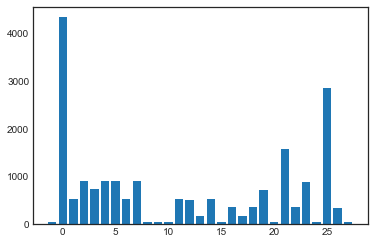

In [208]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [209]:
from sklearn.metrics import f1_score

# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [210]:
f1_sub(fname,'sub/protein_classification.csv')

0.7512368342677388

In [211]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5962398361591438

In [212]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5783064676976434

In [213]:
f1_sub(fname,'sub/se_resnext5.csv')

0.6451386493533474

In [214]:
f1_sub(fname,'sub/resnet34_0.csv')

0.8707000364128348

In [215]:
f1_sub(fname,'sub/ens0.csv')

0.8668413698190406

In [216]:
f1_sub('bojan/submit_InceptionV3.csv','sub/submit_InceptionV3.csv')

0.6432439747575565

In [217]:
f1_sub('bojan/inceptionv3_2.csv','sub/submit_InceptionV3.csv')

0.5987392720028134

In [218]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_1.csv')

0.4642857142857143

In [219]:
f1_sub('bojan/inceptionv3_0.csv','bojan/inceptionv3_2.csv')

0.1426221052396753

In [220]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','sub/submit_InceptionV3.csv')

0.5918623923200268

In [221]:
f1_sub('sub/submit_InceptionResNetV2_3.csv','bojan/inceptionresnetv2_1.csv')

0.6575760350950599